# Cohort Analysis in Python

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from operator import attrgetter
import matplotlib.colors as mcolors

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [4]:
plt.style.use('seaborn')
warnings.simplefilter(action='ignore', category=FutureWarning)

## Loading data

In [7]:
df = pd.read_excel('online_retail_II.xlsx',
                   dtype={'CustomerID': str,
                          'InvoiceID': str},
                   parse_dates=['InvoiceDate'])
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      525461 non-null  object        
 1   StockCode    525461 non-null  object        
 2   Description  522533 non-null  object        
 3   Quantity     525461 non-null  int64         
 4   InvoiceDate  525461 non-null  datetime64[ns]
 5   Price        525461 non-null  float64       
 6   Customer ID  417534 non-null  float64       
 7   Country      525461 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 32.1+ MB


In [14]:
df[pd.isnull(df['Customer ID'])].head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
263,489464,21733,85123a mixed,-96,2009-12-01 10:52:00,0.00,NaN,United Kingdom
283,489463,71477,short,-240,2009-12-01 10:52:00,0.00,NaN,United Kingdom
284,489467,85123A,21733 mixed,-192,2009-12-01 10:53:00,0.00,NaN,United Kingdom
470,489521,21646,NaN,-50,2009-12-01 11:44:00,0.00,NaN,United Kingdom
577,489525,85226C,BLUE PULL BACK RACING CAR,1,2009-12-01 11:49:00,0.55,NaN,United Kingdom


In [15]:
df.dropna(subset=['Customer ID'], inplace=True)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 417534 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      417534 non-null  object        
 1   StockCode    417534 non-null  object        
 2   Description  417534 non-null  object        
 3   Quantity     417534 non-null  int64         
 4   InvoiceDate  417534 non-null  datetime64[ns]
 5   Price        417534 non-null  float64       
 6   Customer ID  417534 non-null  float64       
 7   Country      417534 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 28.7+ MB


I inspect the distribution of the numeric variables - quantity and unit price.

In [17]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Quantity,417534.0,12.758815,101.220424,-9360.0,2.00,4.00,12.00,19152.00
Price,417534.0,3.887547,71.131797,0.0,1.25,1.95,3.75,25111.09
Customer ID,417534.0,15360.645478,1680.811316,12346.0,13983.00,15311.00,16799.00,18287.00


In [20]:
np.sum(df.Quantity < 0)

9839

There are around 9k purchases with negative quantity, most likely returns. I will remove them from the dataset.

In [21]:
df = df[df['Quantity'] > 0]

In [22]:
n_orders = df.groupby(['Customer ID'])['Invoice'].nunique()
mult_orders_perc = np.sum(n_orders > 1) / df['Customer ID'].nunique()
print(f'{100 * mult_orders_perc:.2f}% of customers ordered more than once.')

67.06% of customers ordered more than once.


In [24]:
n_orders

Customer ID
12346.0    11
12347.0     2
12348.0     1
12349.0     3
12351.0     1
           ..
18283.0     6
18284.0     1
18285.0     1
18286.0     2
18287.0     4
Name: Invoice, Length: 4314, dtype: int64

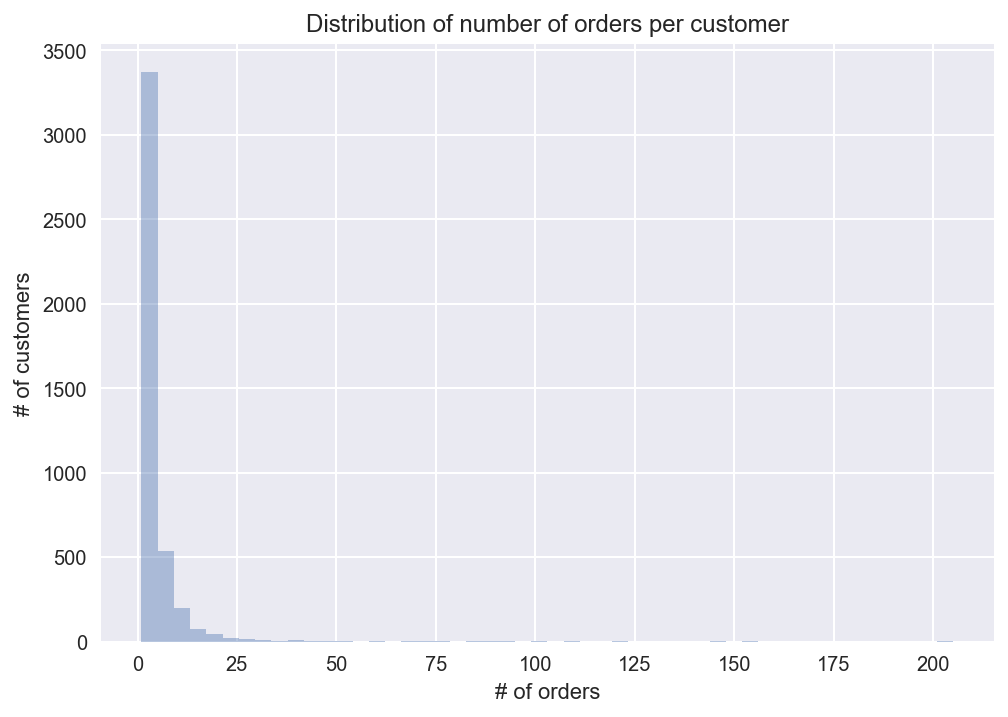

In [23]:
ax = sns.distplot(n_orders, kde=False, hist=True)
ax.set(title='Distribution of number of orders per customer',
       xlabel='# of orders', 
       ylabel='# of customers');

## Cohort analysis

In [25]:
# keep only the relevant data
df = df[['Customer ID', 'Invoice', 'InvoiceDate']].drop_duplicates()

In [26]:
# create two variables: month of order and cohort
df['order_month'] = df['InvoiceDate'].dt.to_period('M')
df['cohort'] = df.groupby('Customer ID')['InvoiceDate'] \
                 .transform('min') \
                 .dt.to_period('M') 

In [27]:
# add an indicator for periods (months since first purchase)
df_cohort = df.groupby(['cohort', 'order_month']) \
              .agg(n_customers=('Customer ID', 'nunique')) \
              .reset_index(drop=False)
df_cohort['period_number'] = (df_cohort.order_month - df_cohort.cohort).apply(attrgetter('n'))

In [28]:
# pivot the data into a form of the matrix
cohort_pivot = df_cohort.pivot_table(index = 'cohort',
                                     columns = 'period_number',
                                     values = 'n_customers')

In [29]:
# divide by the cohort size (month 0) to obtain retention as %
cohort_size = cohort_pivot.iloc[:,0]
retention_matrix = cohort_pivot.divide(cohort_size, axis = 0)

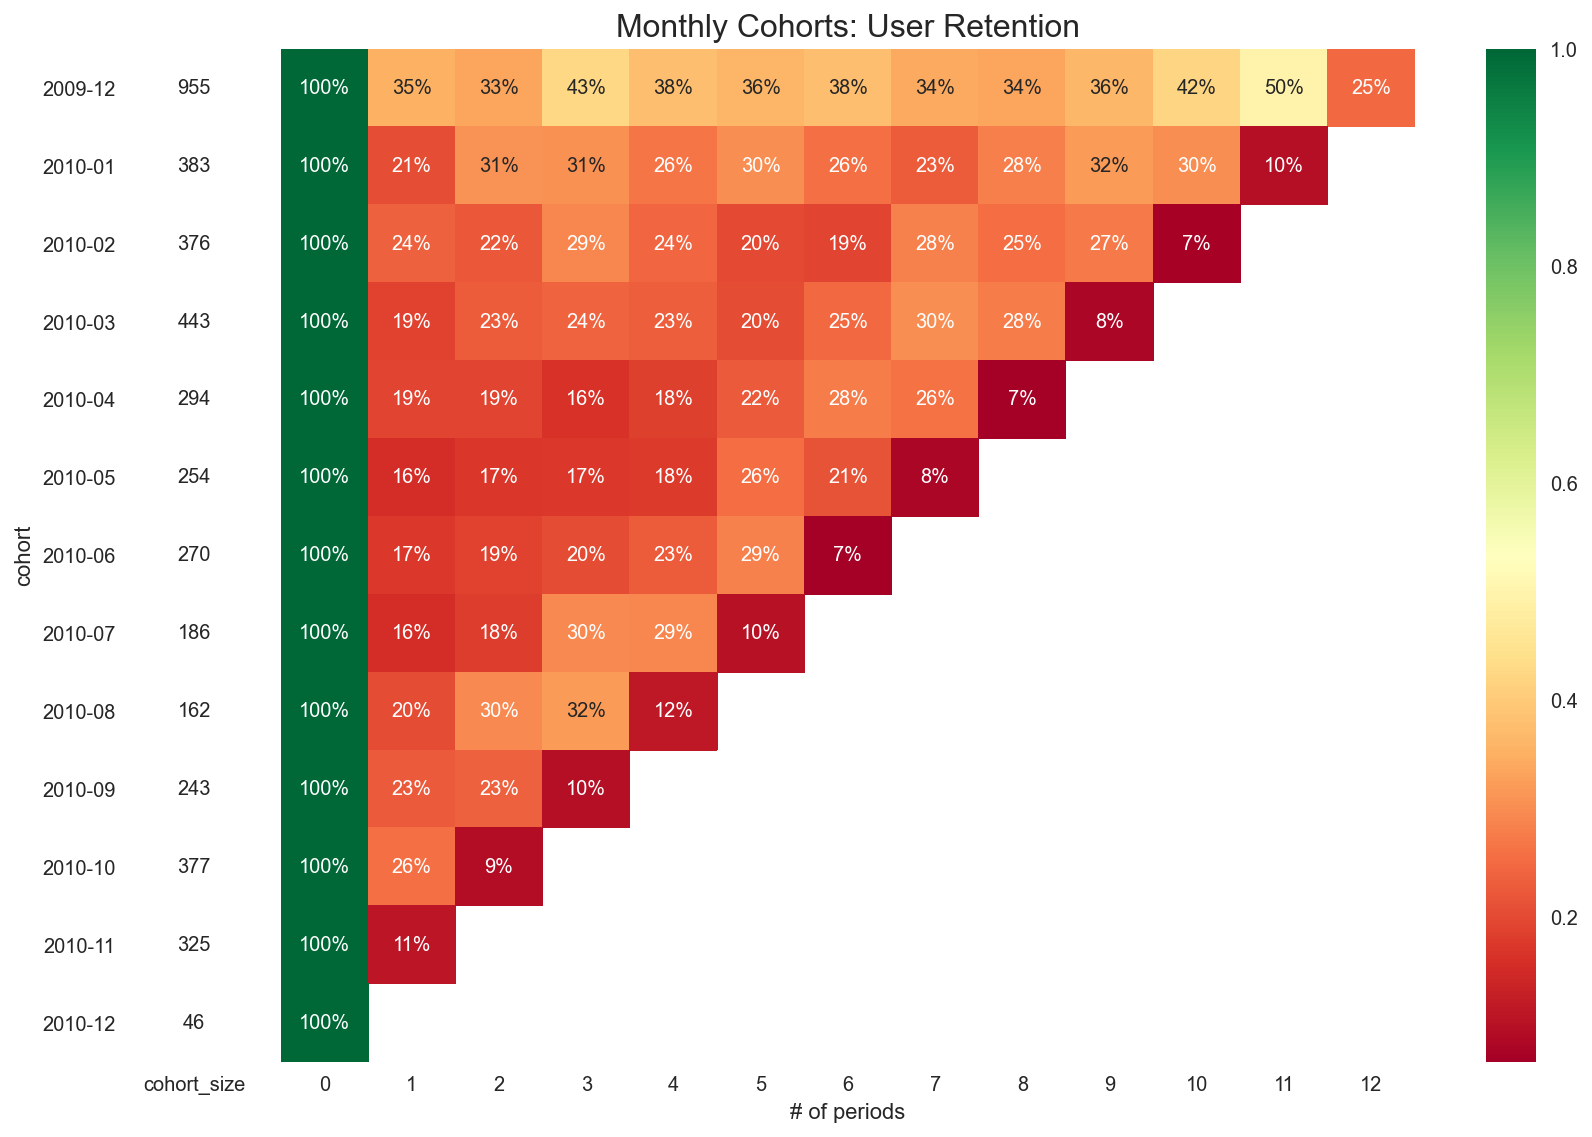

In [30]:
# plot the retention matrix
with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 2, figsize=(12, 8), sharey=True, gridspec_kw={'width_ratios': [1, 11]})
    
    # retention matrix
    sns.heatmap(retention_matrix, 
                mask=retention_matrix.isnull(), 
                annot=True, 
                fmt='.0%', 
                cmap='RdYlGn', 
                ax=ax[1])
    ax[1].set_title('Monthly Cohorts: User Retention', fontsize=16)
    ax[1].set(xlabel='# of periods',
              ylabel='')

    # cohort size
    cohort_size_df = pd.DataFrame(cohort_size).rename(columns={0: 'cohort_size'})
    white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(cohort_size_df, 
                annot=True, 
                cbar=False, 
                fmt='g', 
                cmap=white_cmap, 
                ax=ax[0])

    fig.tight_layout()